# **Cuaderno de ejercitación**



## Descarga de archivos

In [1]:
# Clonar el repositorio desde GitHub
!git clone https://github.com/LeonardoGomezChavez/data_dip_ML.git

Cloning into 'data_dip_ML'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 344.24 KiB | 1.60 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00


In [3]:
%matplotlib inline

import torch
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torch_geometric.utils.convert import from_networkx, to_networkx
from torch_geometric.loader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import data
Los datos contienen información sobre un partido de fútbol. Fueron recopilados de manera que se registraron los pases de los jugadores, anotando quién dio el pase y quién lo recibió. Cada jugador posee un identificador y además se registra su posición en el campo (Goalkeeper, Defender, Midfield, Forward).

In [4]:
training_match_1 = pd.read_csv("/content/data_dip_ML/data/training_match_1.csv")
training_match_2 = pd.read_csv("/content/data_dip_ML/data/training_match_2.csv")
validation_match = pd.read_csv("/content/data_dip_ML/data/validation_match.csv")
testing_match = pd.read_csv("/content/data_dip_ML/data/testing_match.csv")

# Visualizar la red de pases
Cada link (edge) corresponde a un pase. Es importante destacar que cada conexión tiene dirección, es decir, es un grafo direccionado. Por otro lado, cada jugador es un nodo.

In [36]:
training_match_1.head(10)

,match_id,team_id,from_player_id,from_position,to_player_id,to_position,from_position_x,from_position_y,from_position_encoded
0,3795506,914,7788,Forward,3166,Midfield,60.0,40.0,1
1,3795506,914,3166,Midfield,11514,Defender,48.0,35.7,3
2,3795506,914,11514,Defender,7173,Defender,39.2,68.4,0
3,3795506,914,7173,Defender,6954,Defender,25.3,46.4,0
4,3795506,914,6954,Defender,7173,Defender,23.9,18.6,0
5,3795506,914,7173,Defender,7036,Goalkeeper,16.2,44.3,0
6,3795506,914,7788,Forward,7024,Midfield,60.0,40.0,1
7,3795506,914,7024,Midfield,11514,Defender,43.0,49.9,3
8,3795506,914,11514,Defender,7156,Forward,62.5,77.1,0
9,3795506,914,7156,Forward,7788,Forward,83.1,69.0,1


In [6]:
G = nx.from_pandas_edgelist(training_match_1, source="from_player_id", target="to_player_id") #Defino G

nodenames = {}  # Guardamos los nombres de los nodos (jugadores)
for n in G.nodes():
    player_position = training_match_1.loc[training_match_1["from_player_id"] == n, "from_position"]
    if not player_position.empty:
        nodenames[n] = player_position.iloc[0]


In [7]:
nodenames # ID: Position

{7788: 'Forward',
 3166: 'Midfield',
 11514: 'Defender',
 7173: 'Defender',
 6954: 'Defender',
 7036: 'Goalkeeper',
 7024: 'Midfield',
 7156: 'Forward',
 4355: 'Defender',
 8181: 'Midfield',
 7037: 'Forward',
 7131: 'Forward',
 6993: 'Midfield'}

In [8]:
pos = {}  # Guardamos los nombres de los nodos (jugadores)
for player_id in G.nodes():
    player_passes = training_match_1[training_match_1["from_player_id"] == player_id]

    if not player_passes.empty:
        player_positions = player_passes[["from_position_x", "from_position_y"]]
        average_position = player_positions.mean().tolist()

        pos[player_id] = average_position

In [9]:
pos

{7788: [63.788235294117655, 35.11176470588235],
 3166: [63.4440366972477, 27.743119266055047],
 11514: [56.86, 69.91466666666668],
 7173: [43.33425925925926, 43.22314814814815],
 6954: [51.7290909090909, 19.740909090909092],
 7036: [10.915151515151514, 38.25757575757576],
 7024: [61.03052631578948, 45.79157894736843],
 7156: [83.85999999999999, 46.68],
 4355: [68.85471698113207, 7.828301886792453],
 8181: [64.16, 51.93333333333333],
 7037: [77.44230769230771, 18.00384615384615],
 7131: [79.27999999999999, 70.66666666666667],
 6993: [70.62727272727271, 42.61818181818182]}

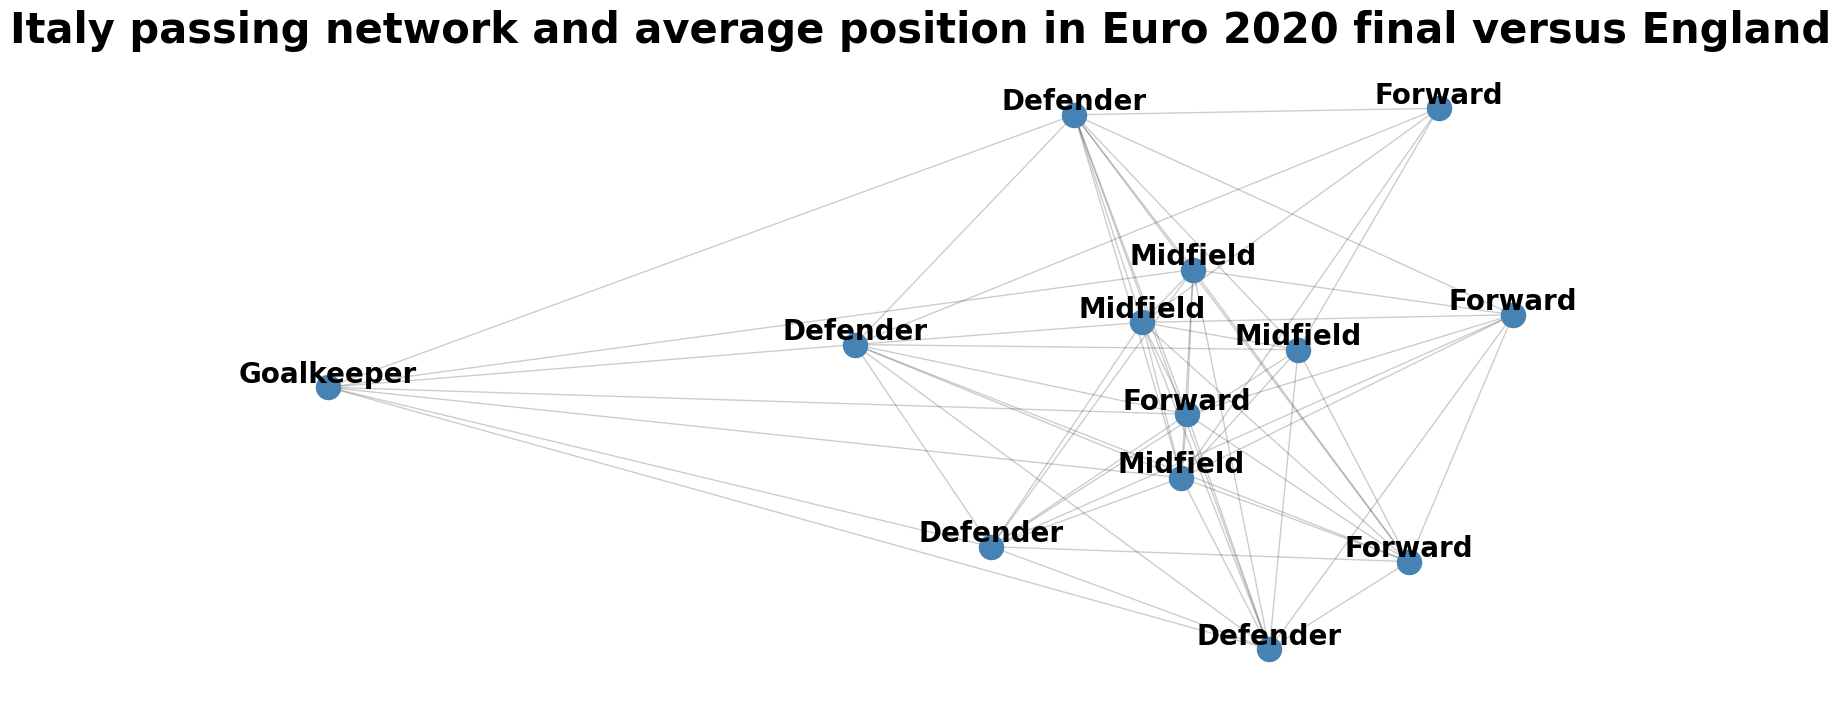

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)

nx.draw_networkx_nodes(G, pos, node_color='steelblue') # Esta función dibuja los nodos del grafo G en las posiciones dadas por el diccionario pos y los colorea de azul.
nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.2) # Esta función dibuja los bordes del grafo G en las posiciones dadas por pos, con flechas para indicar la dirección de los bordes

# dibuja las etiquetas justo encima de los nodos
label_pos = pos
for key in pos:
  label_pos[key][1] += 1.5
nx.draw_networkx_labels(G, pos=label_pos, labels=nodenames, font_size=20, font_weight="bold")


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Italy passing network and average position in Euro 2020 final versus England", fontsize=30, fontweight='bold')
plt.show()

# **Convertir las redes de pases al formato de entrenamiento GNN**

In [11]:
def create_graph_from_dataframe(dataframe: pd.DataFrame):
  # primero crear una representación de rnetworkx del gráfico a partir del Dataframe
  match_network_x_graph = nx.from_pandas_edgelist(
      dataframe, source="from_player_id", target="to_player_id"
  )

  # Convertir en un grafo de pytorch geometric
  graph_for_modelling = from_networkx(match_network_x_graph)

  positions = []
  for player_id in match_network_x_graph.nodes():
      player_passes = dataframe[dataframe["from_player_id"] == player_id]

      if not player_passes.empty:
          player_positions = player_passes[["from_position_x", "from_position_y"]]
          average_position = player_positions.mean().tolist()
          positions.append(average_position)

  graph_for_modelling.x = torch.tensor(positions, dtype=torch.float) / 100

  encoded_positions = []
  for player_id in match_network_x_graph.nodes():
     player_pass = dataframe[dataframe["from_player_id"] == player_id]["from_position_encoded"]

     if not player_pass.empty:
        encoded_position = player_pass.iloc[0]
        encoded_positions.append(encoded_position)

  graph_for_modelling.y = torch.tensor(encoded_positions, dtype=torch.long)

  # asegurarse de que el edge_index sea del tipo de datos correcto
  graph_for_modelling.edge_index = graph_for_modelling.edge_index.type(
      torch.LongTensor
  )

  # agrega el ID del jugador como una característica para ayudarnos al gráficar más adelante
  graph_for_modelling.player_id = [n  for n in match_network_x_graph.nodes()]

  return graph_for_modelling

## Creamos los grafos de entrenamiento, validación y test

In [12]:
modelling_train = [create_graph_from_dataframe(match) for match in [training_match_1, training_match_2]]
modelling_train

[Data(edge_index=[2, 122], num_nodes=13, x=[13, 2], y=[13], player_id=[13]),
 Data(edge_index=[2, 72], num_nodes=10, x=[10, 2], y=[10], player_id=[10])]

In [13]:
modelling_val = create_graph_from_dataframe(validation_match)
modelling_val

Data(edge_index=[2, 96], num_nodes=11, x=[11, 2], y=[11], player_id=[11])

In [14]:
modelling_test = create_graph_from_dataframe(testing_match)
modelling_test

Data(edge_index=[2, 120], num_nodes=12, x=[12, 2], y=[12], player_id=[12])

# Creamos un modelo para entrenamiento


In [15]:
#@title # Módulos necesarios
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
import torch
import torch.nn.functional as F
from torch.nn import Linear

In [16]:
#@title # Otras características importantes
NUM_FEATURES = modelling_train[0].x.shape[1]
NUM_CLASSES = len(training_match_1["from_position_encoded"].drop_duplicates())
print(f'NUM_FEATURES: {NUM_FEATURES}') # Posición x e y promedio
print(f'NUM_CLASSES: {NUM_CLASSES}') # Goalkeeper, Defender, Midfield, Forward

NUM_FEATURES: 2
NUM_CLASSES: 4


## **Modelo 1**

In [17]:
class GCN_1(torch.nn.Module):
    def __init__(self):
        torch.manual_seed(12345) # Seteamos una semilla
        super(GCN_1, self).__init__()
        self.conv1 = GCNConv(NUM_FEATURES, 256)
        self.conv2 = GCNConv(256, 128)
        self.lin = Linear(128, NUM_CLASSES)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(x)
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

In [18]:
#@title # Función de entrenamiento
def train_model(models,train_data):
    models.train()
    for data in train_data:
      out = models(data) # Perform a single forward pass.
      loss = criterion(out, data.y)  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      optimizer.zero_grad()  # Clear gradients.

    return models

In [19]:
#@title # Función de evaluación
def evaluate_model(models,test_data):
    models.eval()
    correct = 0
    total_samples = 0

    model_outputs = []
    targets = []
    for data in test_data:
      model_output = models(data)
      predicted_class = model_output.argmax(dim=1)

      correct += int((predicted_class == data.y).sum())
      total_samples += len(data.y)

      # store these to get the loss
      model_outputs.extend(model_output.tolist())
      targets.extend(data.y.tolist())

    accuracy = correct/total_samples
    loss = criterion(torch.tensor(model_outputs), torch.tensor(targets))

    return accuracy, loss

In [20]:
model_1 = GCN_1().to(device)
print(model_1)

GCN_1(
  (conv1): GCNConv(2, 256)
  (conv2): GCNConv(256, 128)
  (lin): Linear(in_features=128, out_features=4, bias=True)
)


In [21]:
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [22]:
train_accuraacies = []
validation_accuraacies = []
validation_losses = []
train_losses = []
for epoch in range(1, 101): # Aqui cambiar el número de epocas de entrenamiento
    train_accuracies = []
    model = train_model(model_1,modelling_train)

    train_acc, train_loss = evaluate_model(model_1,modelling_train)
    train_losses.append(train_loss)
    val_acc, val_loss = evaluate_model(model_1,[modelling_val])
    validation_losses.append(val_loss)


    train_accuraacies.append(train_acc)
    validation_accuraacies.append(val_acc)

    # # guarde el modelo si es mejor que los anteriores
    if val_loss.item() <= min(validation_losses).item():
      torch.save(model, "best_model.pkl")

    if epoch % 50 == 0:
      print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Train Loss: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

best_validation_loss = min(validation_losses)
best_epoch = validation_losses.index(best_validation_loss)
accuracy_at_best_epoch = validation_accuraacies[best_epoch]
print(f"The best result was achieved after {best_epoch} epochs with a validation accuracy of {accuracy_at_best_epoch} and a loss of {best_validation_loss}")

Epoch: 50, Train Acc: 0.3913, Train Loss: 0.3913, Val Acc: 0.3636, Val Loss: 1.2755
Epoch: 100, Train Acc: 0.4348, Train Loss: 0.4348, Val Acc: 0.2727, Val Loss: 1.3015
The best result was achieved after 68 epochs with a validation accuracy of 0.36363636363636365 and a loss of 1.269690752029419


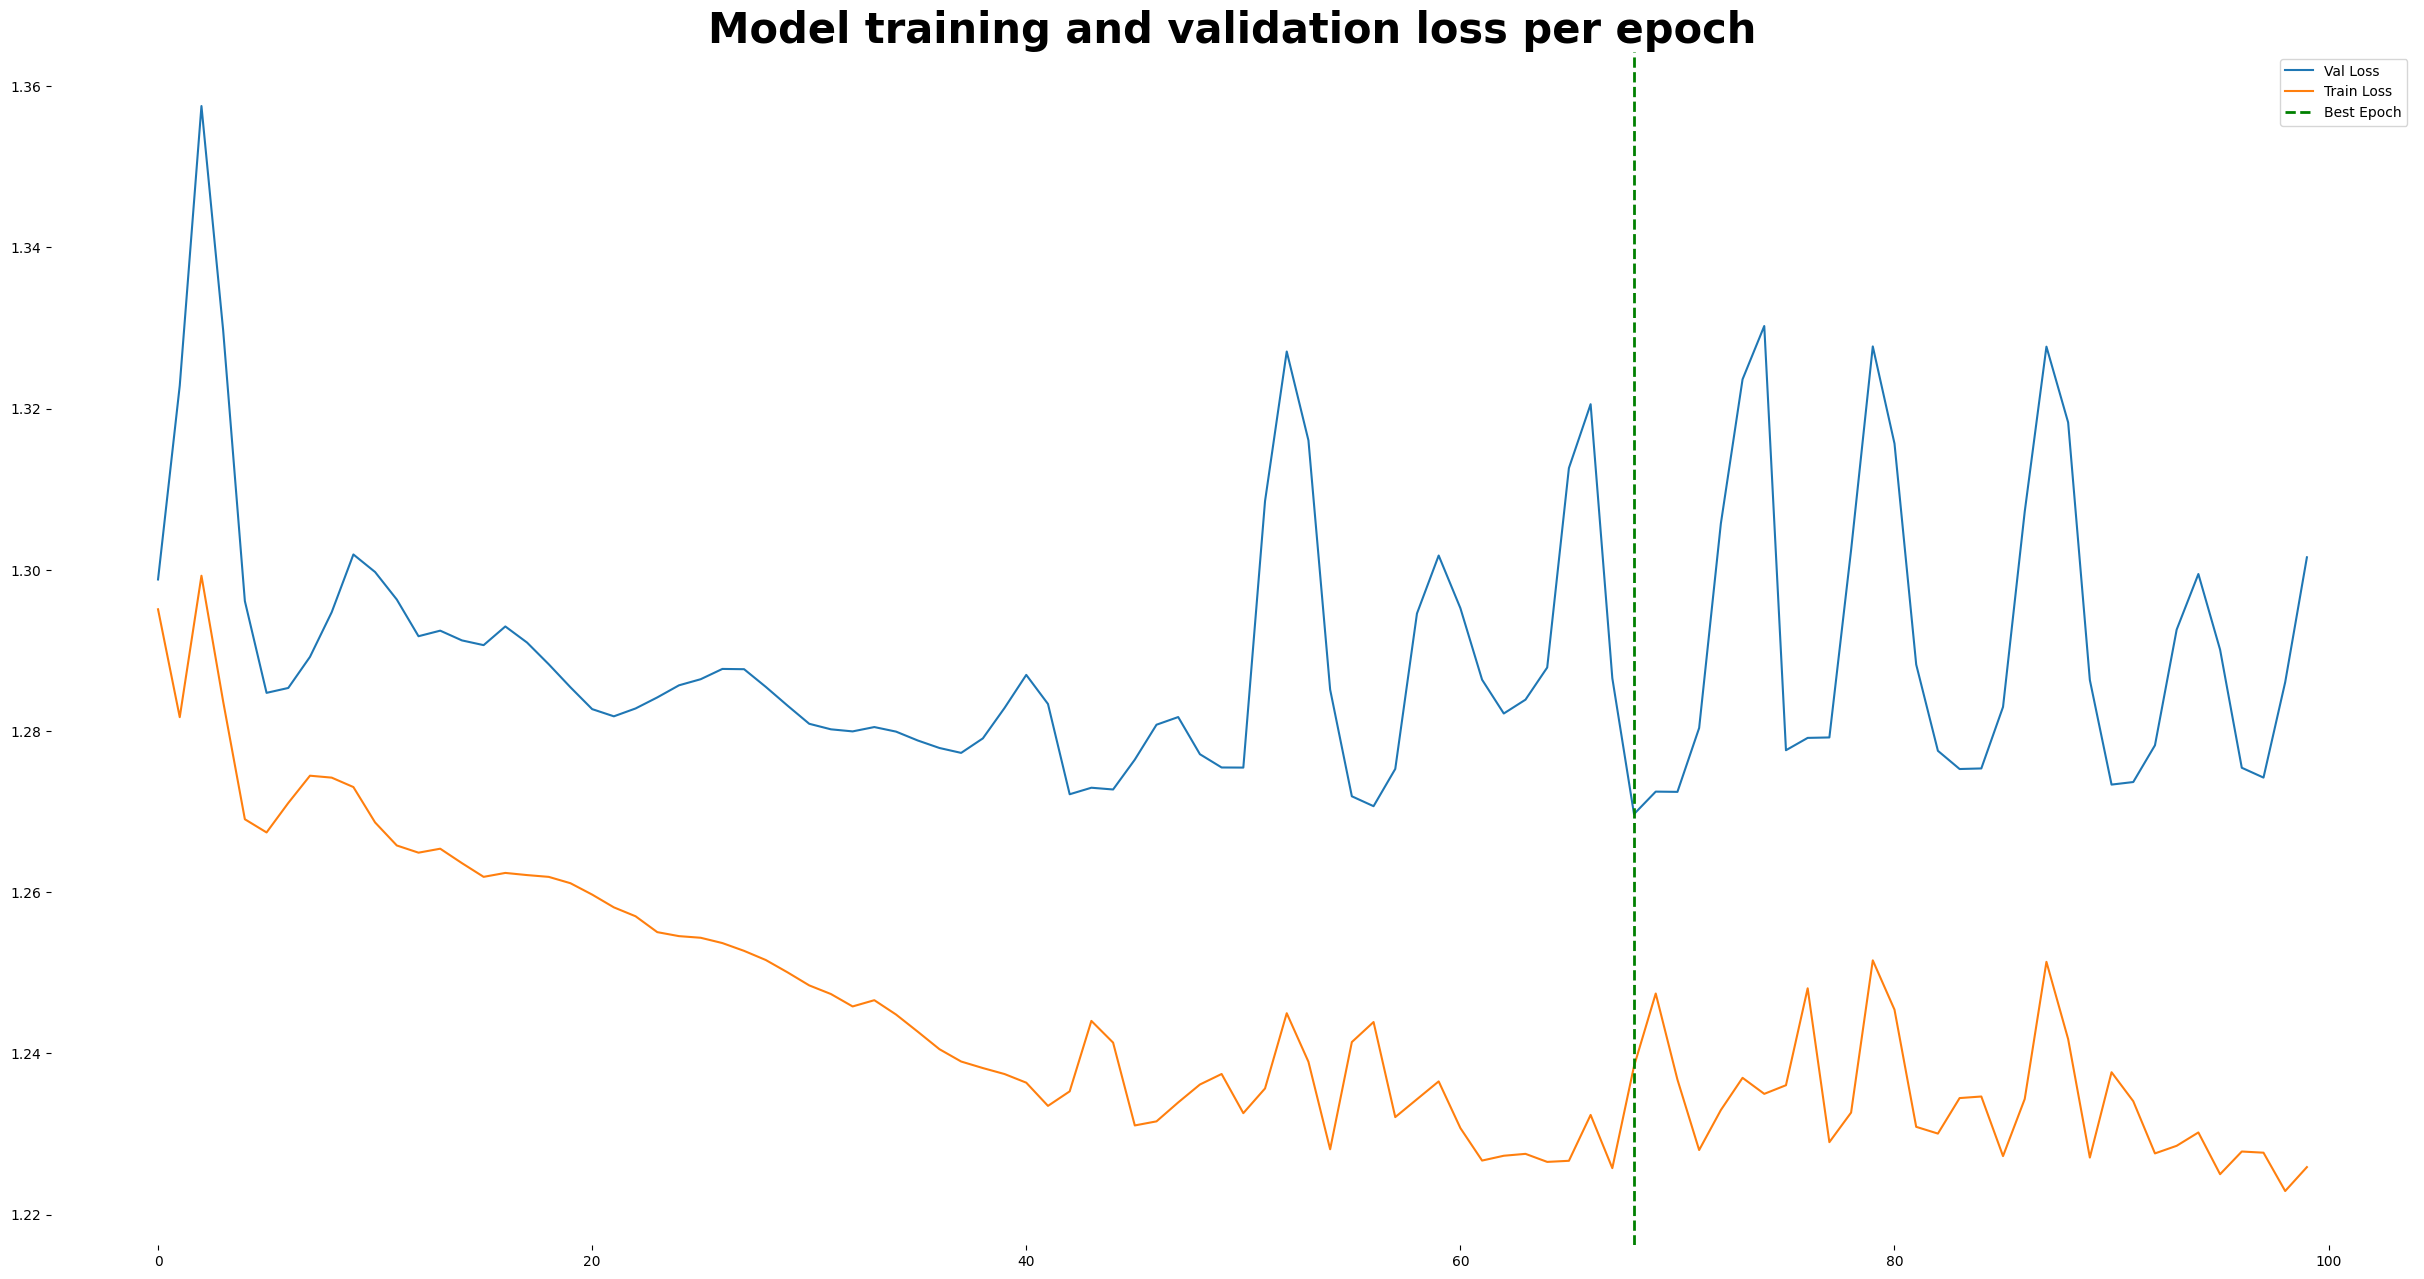

In [23]:
#@title # PLOT
fig, ax = plt.subplots()
fig.set_size_inches(30.5, 15.5)

plt.plot(validation_losses)
plt.plot(train_losses)
plt.axvline(x=best_epoch, color="green", linewidth=2, linestyle='dashed')
plt.legend(['Val Loss', 'Train Loss', "Best Epoch"])


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Model training and validation loss per epoch", fontsize=30, fontweight='bold')
plt.savefig('model_loss.png')
plt.show()

In [24]:
#@title # Algunas predicciones

# load the model
best_model = torch.load("best_model.pkl")

# predict the output
model_output = model(modelling_test)
predicted_class = model_output.argmax(dim=1)

# calculate the accuracy
int((predicted_class == modelling_test.y).sum())/len(modelling_test.y)

<ipython-input-24-99f9efd89b8e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("best_model.pkl")


0.25

In [25]:
# map the predicted and actual classes to the class name
predicted_class_names = []

for i in range(len(predicted_class)):

  predicted_class_names.append(
      testing_match.loc[
        testing_match["from_position_encoded"]==predicted_class[i].item(),
        "from_position"
      ].iloc[0]
  )
  i+=1

modelling_test.predicted_class_name = predicted_class_names
modelling_test.predicted_class_name

['Forward',
 'Forward',
 'Forward',
 'Forward',
 'Forward',
 'Forward',
 'Forward',
 'Forward',
 'Forward',
 'Forward',
 'Forward',
 'Forward']

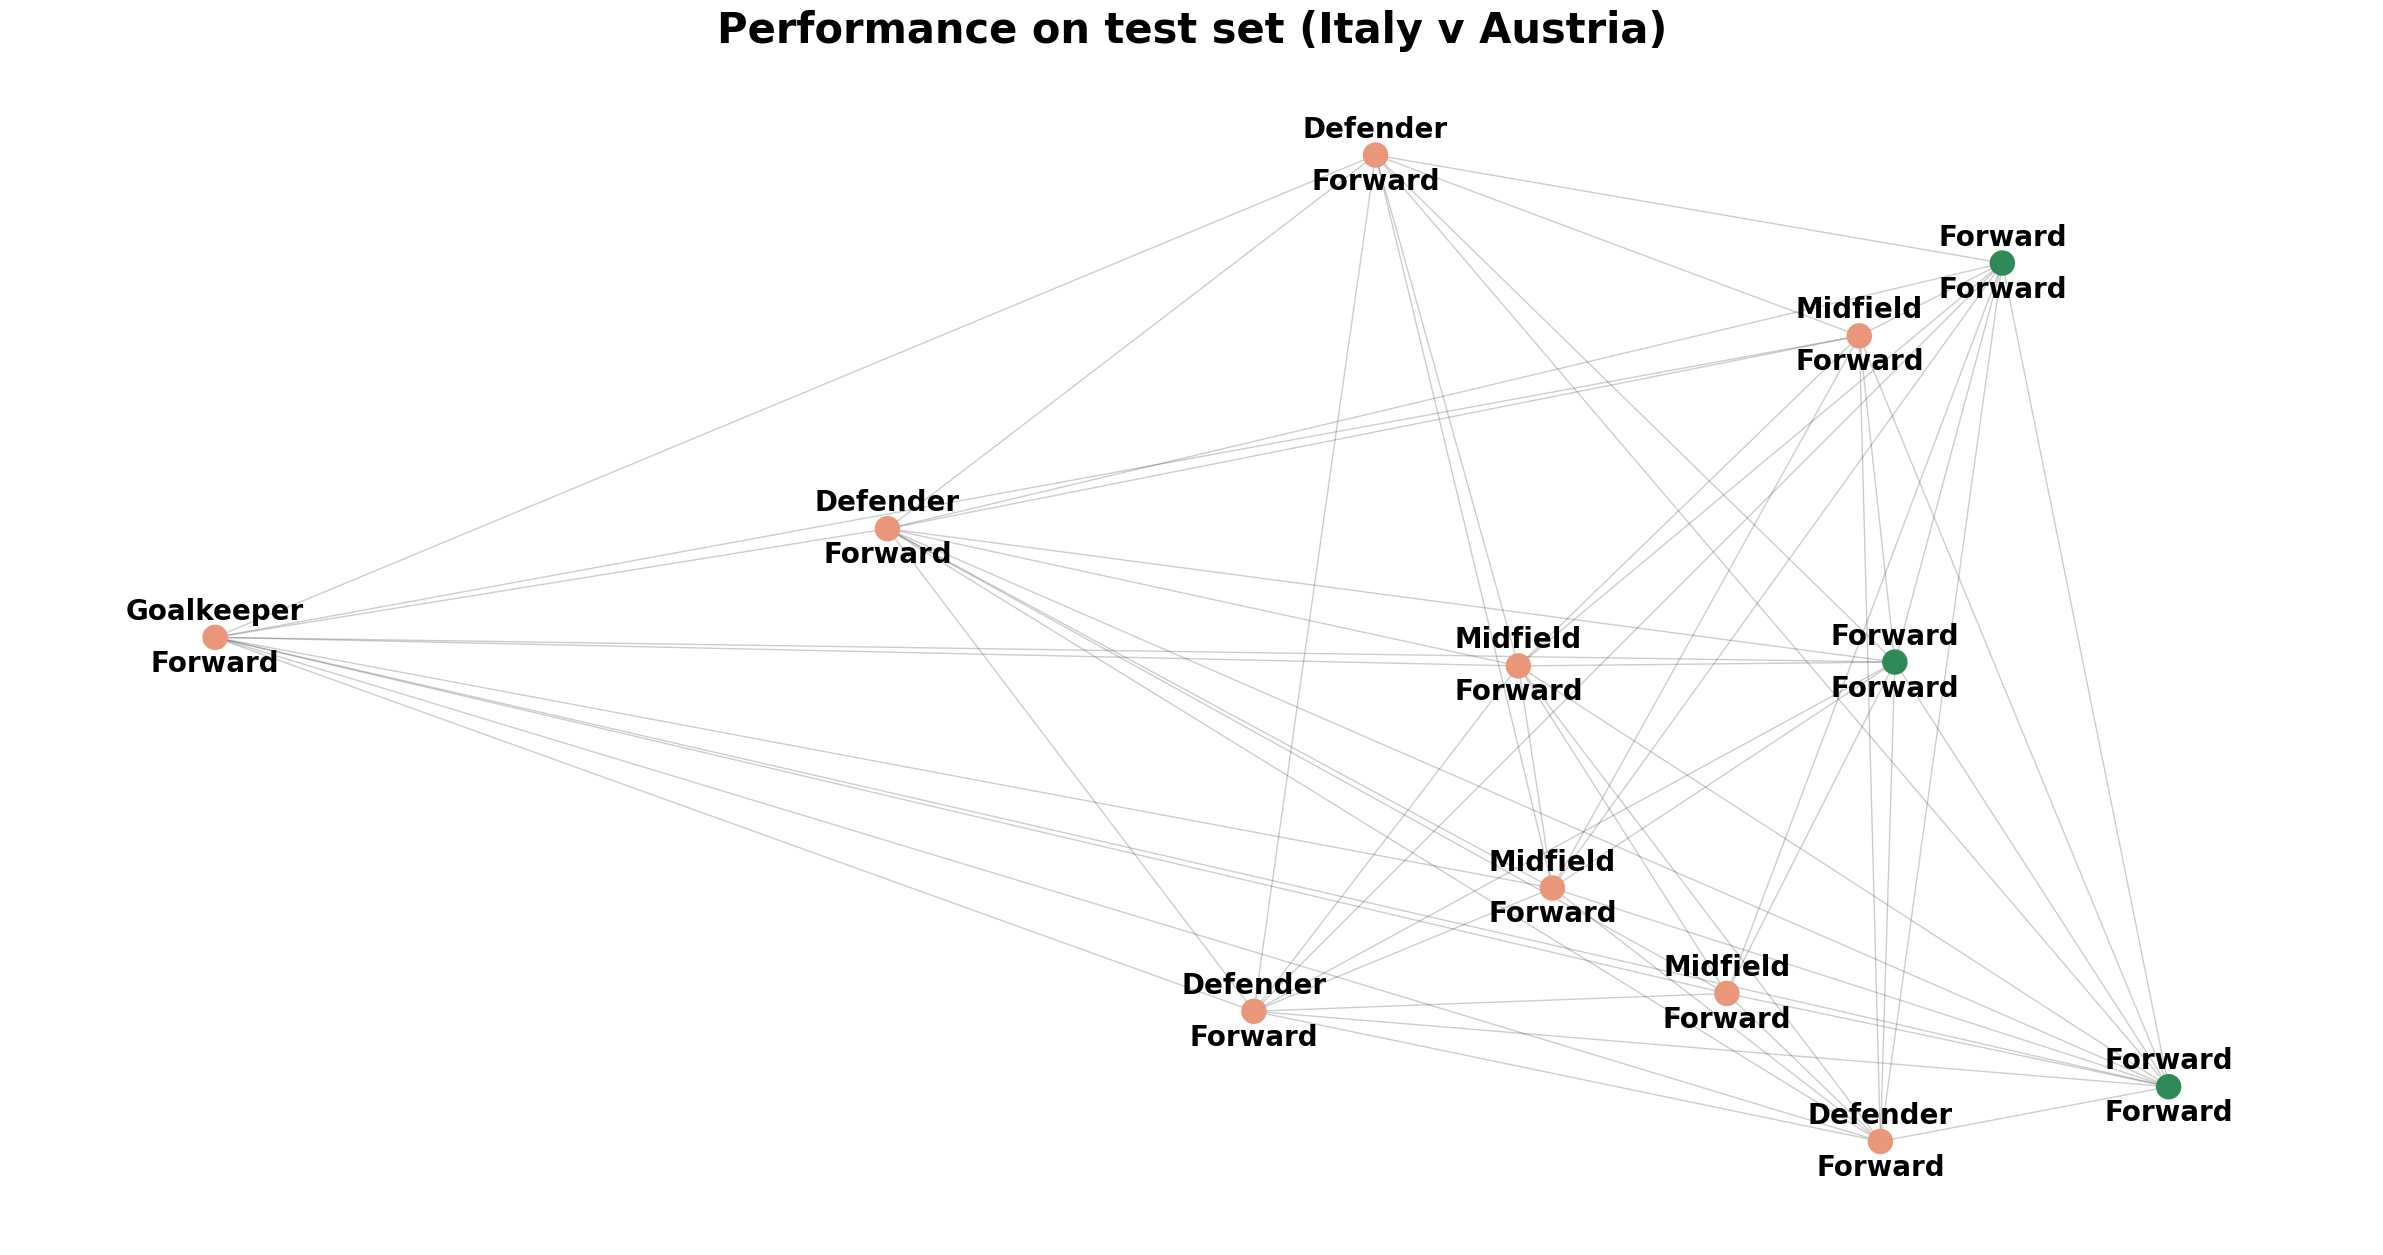

In [26]:
#@title # Visualizando las predicciones
import copy

G = nx.from_pandas_edgelist(testing_match, source="from_player_id", target="to_player_id")
actual_position = {
    n:testing_match.loc[
        testing_match["from_player_id"]==n, "from_position"
    ].iloc[0] for n in G.nodes()
}

# Crea un diccionario con el ID del jugador y la clase prevista (esto ayudará a visualizar los datos).
predicted_positions = {}
for i in range(len(modelling_test.predicted_class_name)):
  predicted_positions[modelling_test.player_id[i]] = modelling_test.predicted_class_name[i]

# Obteiene la posición promedio para trazar en x e y
average_position = {
    n:list(testing_match.loc[
        testing_match["from_player_id"]==n, ["from_position_x", "from_position_y"]
    ].mean()) for n in G.nodes()
}

fig, ax = plt.subplots()
fig.set_size_inches(30.5, 15.5)

# Colorea los nodos según la predicción (verde_correcto, rojo_incorrecto)
node_colours = []
for n in G.nodes():
  node_colours.append("seagreen" if actual_position[n] == predicted_positions[n] else "darksalmon")

nx.draw_networkx_nodes(G, average_position, node_color=node_colours)
nx.draw_networkx_edges(G, average_position, arrows=True, alpha=0.2)

# Dibuja las etiquetas justo encima y debajo de los nodos.
actual_label_pos = copy.deepcopy(average_position)
predicted_label_pos = copy.deepcopy(average_position)
for key in average_position:
  actual_label_pos[key][1] += 1.5
  predicted_label_pos[key][1] -= 1.5

nx.draw_networkx_labels(G, pos=actual_label_pos, labels=actual_position, font_size=20, font_weight="bold")
nx.draw_networkx_labels(G, pos=predicted_label_pos, labels=predicted_positions, font_size=20, font_weight="bold")


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Performance on test set (Italy v Austria)", fontsize=30, fontweight='bold')
plt.savefig('test_set_performance.png')
plt.show()

# **Actividates**


#*   Buscar la manera de mejorar el modelo. Se puede cambiar el número y tipo de capas, funciones de activación, optimizadores, número de epocas, etc.


## **Model 2**

### Este modelo se corresponde con un buen resultado. Se puede observar e intentar replicar los resultados.

In [27]:
HIDDEN_LAYER_SIZE=256

In [28]:
class GCN_2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345) # Seteamos una semilla
        self.conv1 = SAGEConv(NUM_FEATURES, HIDDEN_LAYER_SIZE)
        self.lin_1 = Linear(HIDDEN_LAYER_SIZE, NUM_CLASSES*4)
        self.lin_2 = Linear(NUM_CLASSES*4, NUM_CLASSES)


    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin_1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin_2(x)

        return F.log_softmax(x, dim=1)

In [29]:
model_2 = GCN_2().to(device)
print(model_2)

GCN_2(
  (conv1): SAGEConv(2, 256, aggr=mean)
  (lin_1): Linear(in_features=256, out_features=16, bias=True)
  (lin_2): Linear(in_features=16, out_features=4, bias=True)
)


In [30]:
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [31]:
train_accuraacies = []
validation_accuraacies = []
validation_losses = []
train_losses = []
for epoch in range(1, 3001):
    train_accuracies = []
    model = train_model(model_2,modelling_train)

    train_acc, train_loss = evaluate_model(model_2,modelling_train)
    train_losses.append(train_loss)
    val_acc, val_loss = evaluate_model(model_2,[modelling_val])
    validation_losses.append(val_loss)


    train_accuraacies.append(train_acc)
    validation_accuraacies.append(val_acc)

    # # guarde el modelo si es mejor que los anteriores
    if val_loss.item() <= min(validation_losses).item():
      torch.save(model, "best_model2.pkl")

    if epoch % 50 == 0:
      print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Train Loss: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

best_validation_loss = min(validation_losses)
best_epoch = validation_losses.index(best_validation_loss)
accuracy_at_best_epoch = validation_accuraacies[best_epoch]
print(f"The best result was achieved after {best_epoch} epochs with a validation accuracy of {accuracy_at_best_epoch} and a loss of {best_validation_loss}")

Epoch: 50, Train Acc: 0.3913, Train Loss: 0.3913, Val Acc: 0.3636, Val Loss: 1.2230
Epoch: 100, Train Acc: 0.5217, Train Loss: 0.5217, Val Acc: 0.5455, Val Loss: 1.1221
Epoch: 150, Train Acc: 0.6087, Train Loss: 0.6087, Val Acc: 0.4545, Val Loss: 1.0346
Epoch: 200, Train Acc: 0.6087, Train Loss: 0.6087, Val Acc: 0.4545, Val Loss: 0.9703
Epoch: 250, Train Acc: 0.6957, Train Loss: 0.6957, Val Acc: 0.5455, Val Loss: 0.9238
Epoch: 300, Train Acc: 0.7391, Train Loss: 0.7391, Val Acc: 0.5455, Val Loss: 0.8667
Epoch: 350, Train Acc: 0.7826, Train Loss: 0.7826, Val Acc: 0.5455, Val Loss: 0.8134
Epoch: 400, Train Acc: 0.7826, Train Loss: 0.7826, Val Acc: 0.6364, Val Loss: 0.7628
Epoch: 450, Train Acc: 0.7826, Train Loss: 0.7826, Val Acc: 0.5455, Val Loss: 0.7383
Epoch: 500, Train Acc: 0.8696, Train Loss: 0.8696, Val Acc: 0.7273, Val Loss: 0.7028
Epoch: 550, Train Acc: 0.8261, Train Loss: 0.8261, Val Acc: 0.6364, Val Loss: 0.6599
Epoch: 600, Train Acc: 0.8261, Train Loss: 0.8261, Val Acc: 0.5455

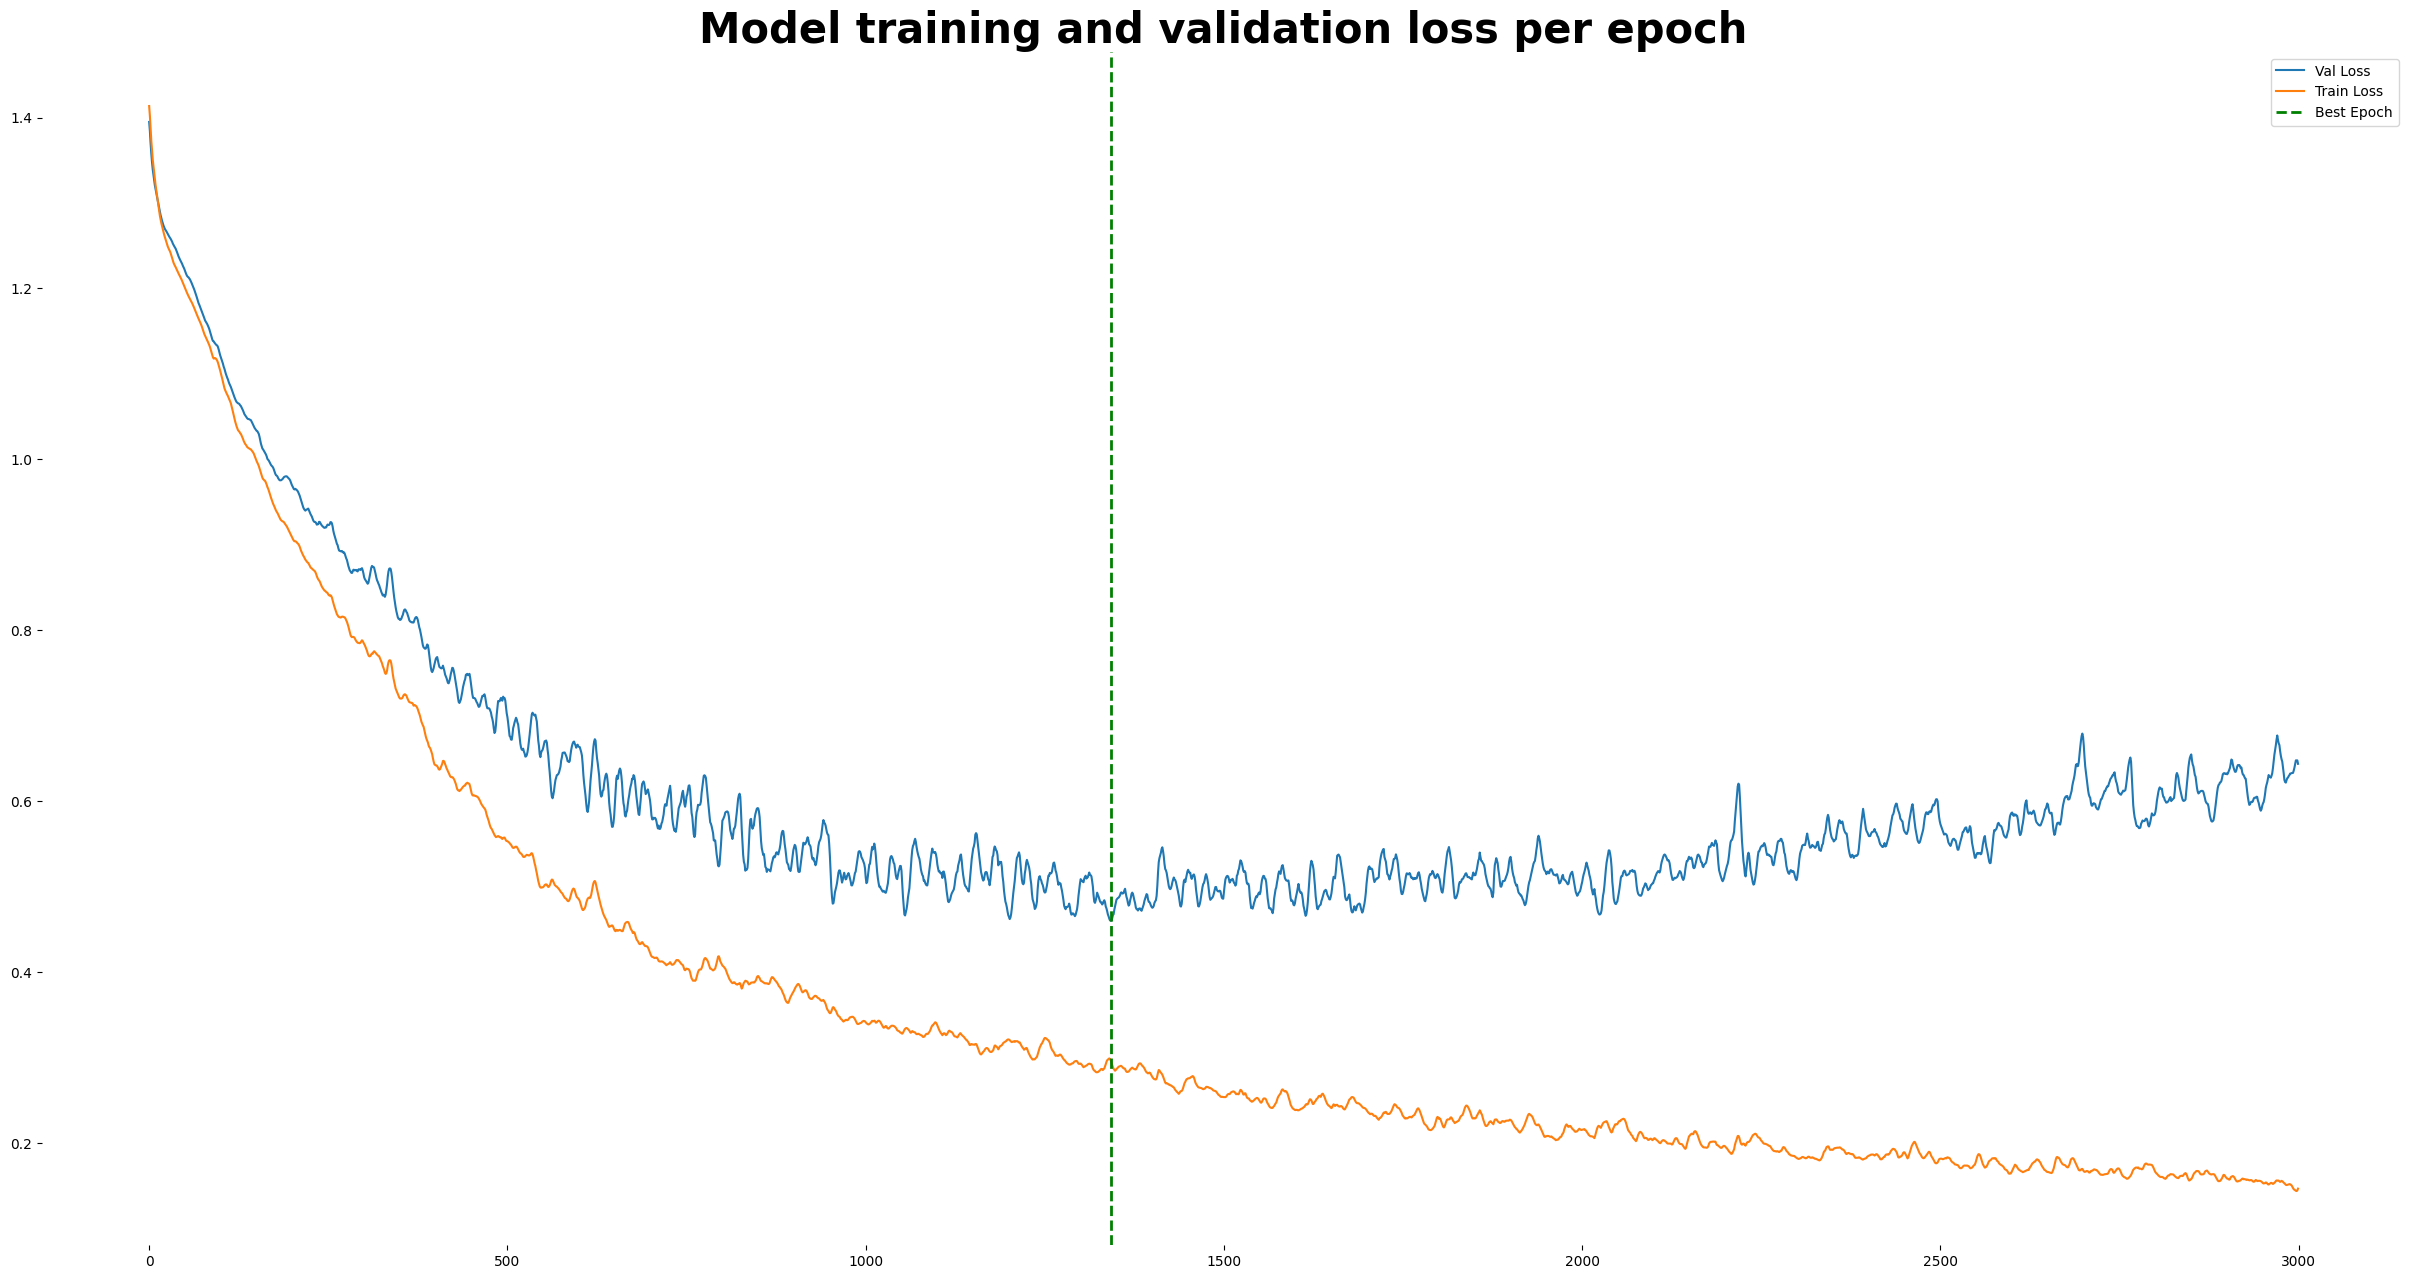

In [32]:
#@title # PLOT
fig, ax = plt.subplots()
fig.set_size_inches(30.5, 15.5)

plt.plot(validation_losses)
plt.plot(train_losses)
plt.axvline(x=best_epoch, color="green", linewidth=2, linestyle='dashed')
plt.legend(['Val Loss', 'Train Loss', "Best Epoch"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Model training and validation loss per epoch", fontsize=30, fontweight='bold')
plt.savefig('model_loss.png')
plt.show()

In [33]:
#@title # Algunas predicciones
# #Carga el mejor modelo
best_model = torch.load("best_model2.pkl")

# predicción de las salidas
model_output = model(modelling_test)
predicted_class = model_output.argmax(dim=1)

# calcula la accuracy
int((predicted_class == modelling_test.y).sum())/len(modelling_test.y)

<ipython-input-33-f99ab6f3bbe1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("best_model2.pkl")


0.9166666666666666

In [34]:
# asignar las clases previstas y reales al nombre de la clase
predicted_class_names = []

for i in range(len(predicted_class)):

  predicted_class_names.append(
      testing_match.loc[
        testing_match["from_position_encoded"]==predicted_class[i].item(),
        "from_position"
      ].iloc[0]
  )
  i+=1

modelling_test.predicted_class_name = predicted_class_names
modelling_test.predicted_class_name

['Defender',
 'Midfield',
 'Midfield',
 'Forward',
 'Defender',
 'Forward',
 'Defender',
 'Forward',
 'Midfield',
 'Defender',
 'Goalkeeper',
 'Forward']

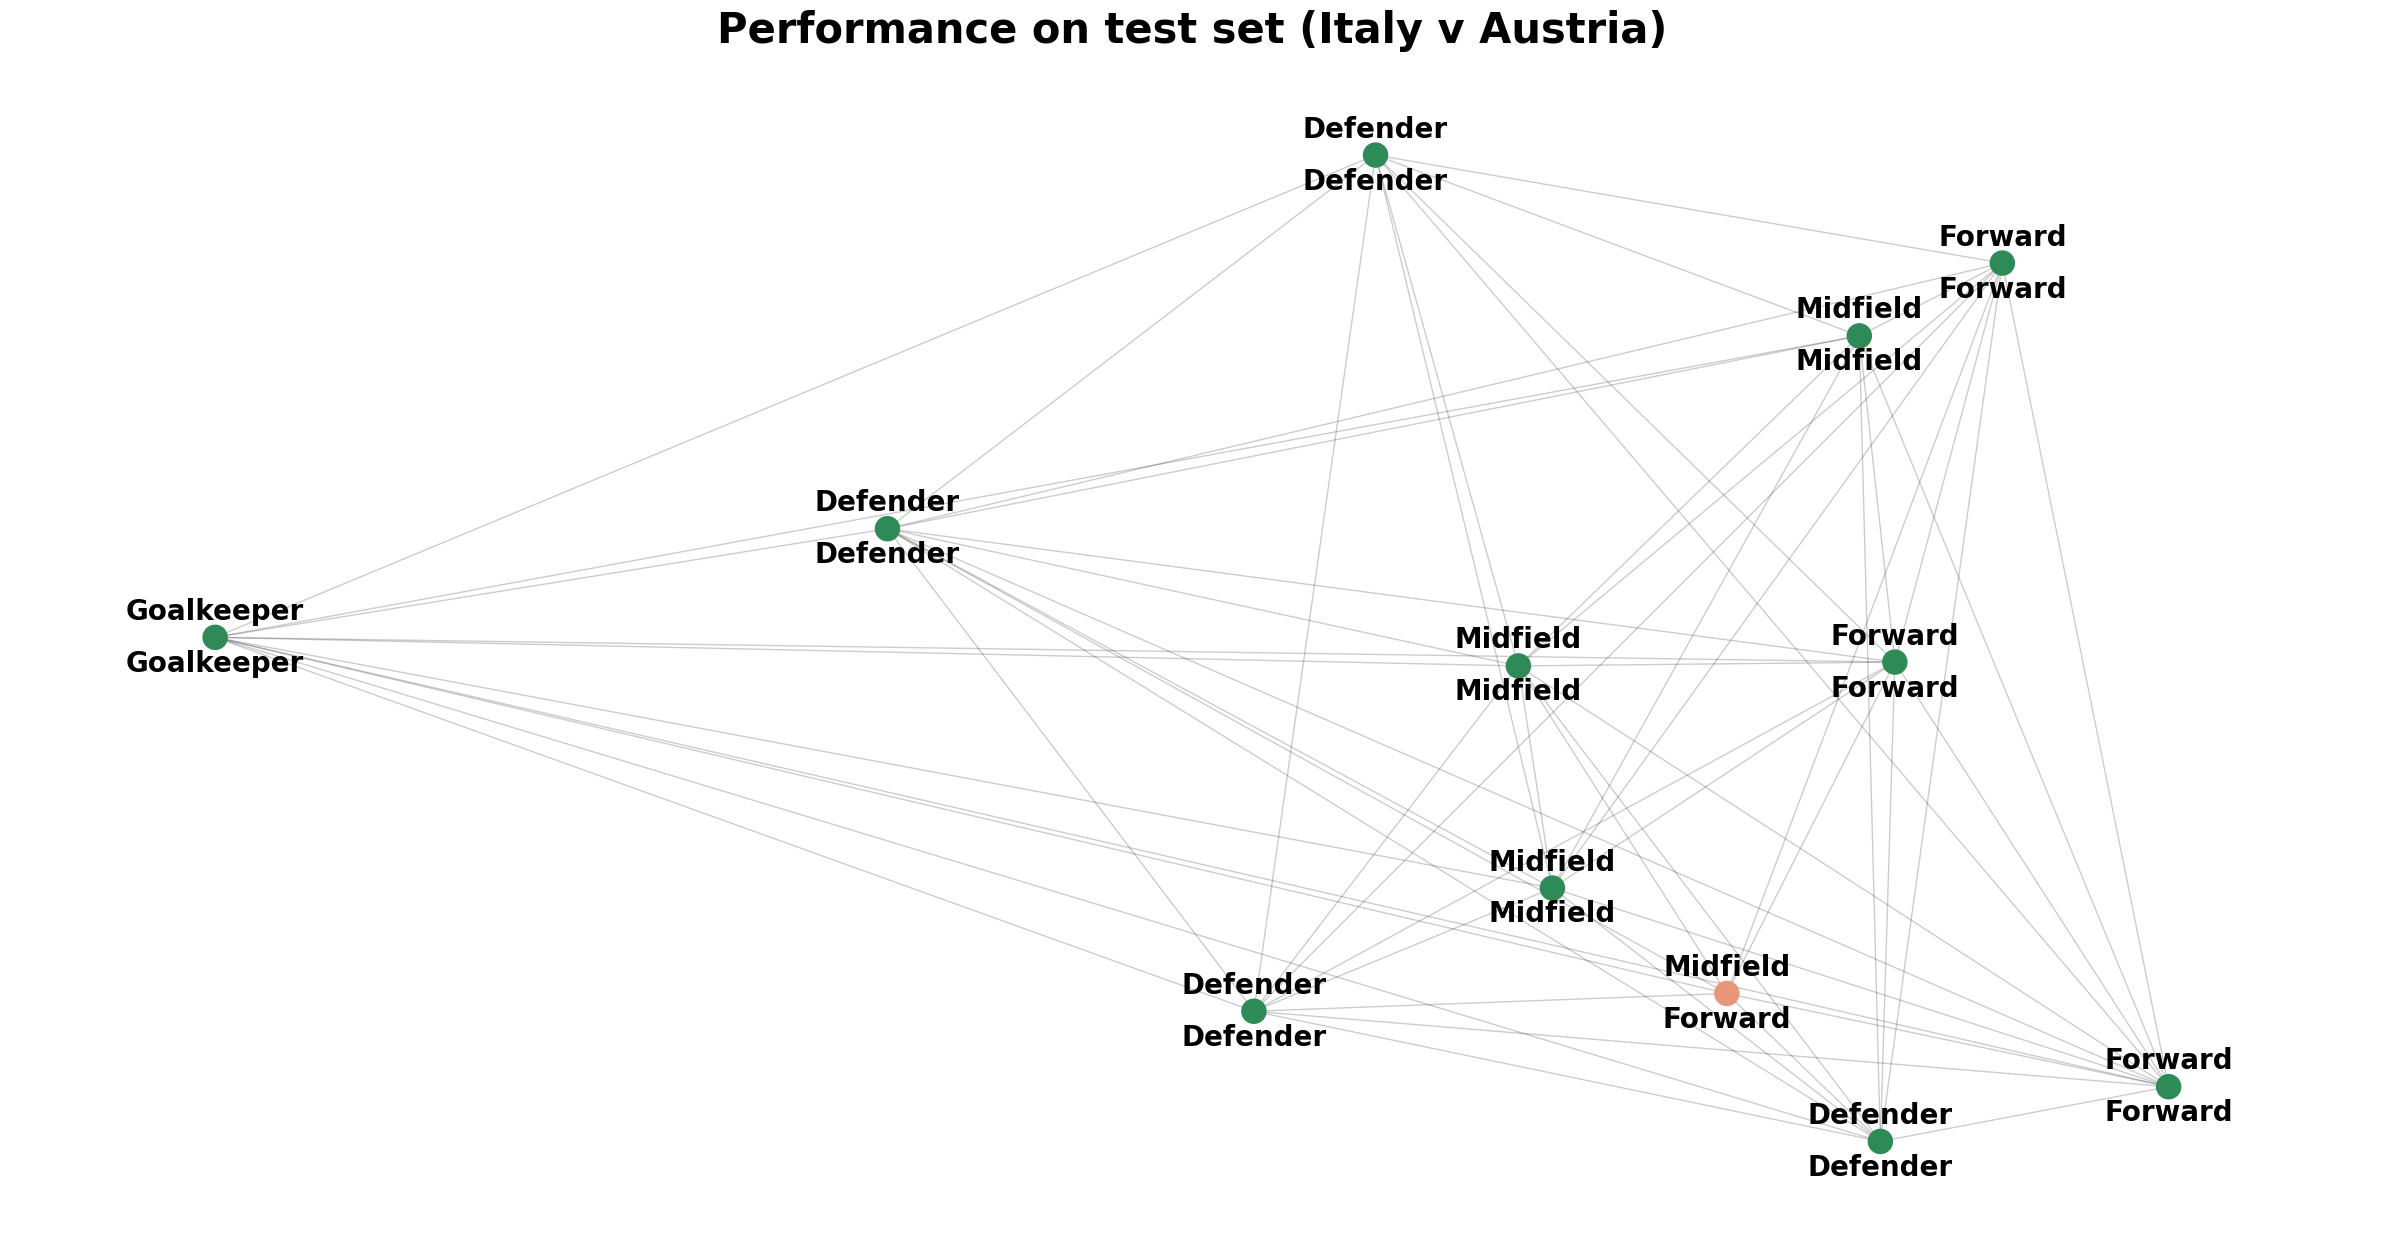

In [35]:
#@title # Visualizando las predicciones
import copy

G = nx.from_pandas_edgelist(testing_match, source="from_player_id", target="to_player_id")
actual_position = {
    n:testing_match.loc[
        testing_match["from_player_id"]==n, "from_position"
    ].iloc[0] for n in G.nodes()
}

# Crea un diccionario con el ID del jugador y la clase prevista (esto ayudará a visualizar los datos).
predicted_positions = {}
for i in range(len(modelling_test.predicted_class_name)):
  predicted_positions[modelling_test.player_id[i]] = modelling_test.predicted_class_name[i]

# Obteiene la posición promedio para trazar en x e y
average_position = {
    n:list(testing_match.loc[
        testing_match["from_player_id"]==n, ["from_position_x", "from_position_y"]
    ].mean()) for n in G.nodes()
}

fig, ax = plt.subplots()
fig.set_size_inches(30.5, 15.5)

# Colorea los nodos según la predicción (verde_correcto, rojo_incorrecto)
node_colours = []
for n in G.nodes():
  node_colours.append("seagreen" if actual_position[n] == predicted_positions[n] else "darksalmon")

nx.draw_networkx_nodes(G, average_position, node_color=node_colours)
nx.draw_networkx_edges(G, average_position, arrows=True, alpha=0.2)

# Dibuja las etiquetas justo encima y debajo de los nodos.
actual_label_pos = copy.deepcopy(average_position)
predicted_label_pos = copy.deepcopy(average_position)
for key in average_position:
  actual_label_pos[key][1] += 1.5
  predicted_label_pos[key][1] -= 1.5

nx.draw_networkx_labels(G, pos=actual_label_pos, labels=actual_position, font_size=20, font_weight="bold")
nx.draw_networkx_labels(G, pos=predicted_label_pos, labels=predicted_positions, font_size=20, font_weight="bold")


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Performance on test set (Italy v Austria)", fontsize=30, fontweight='bold')
plt.savefig('test_set_performance.png')
plt.show()